# Audio classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path 
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [3]:
bs = 32

In [4]:
path = %pwd
path = Path(f'{path}/../data/')

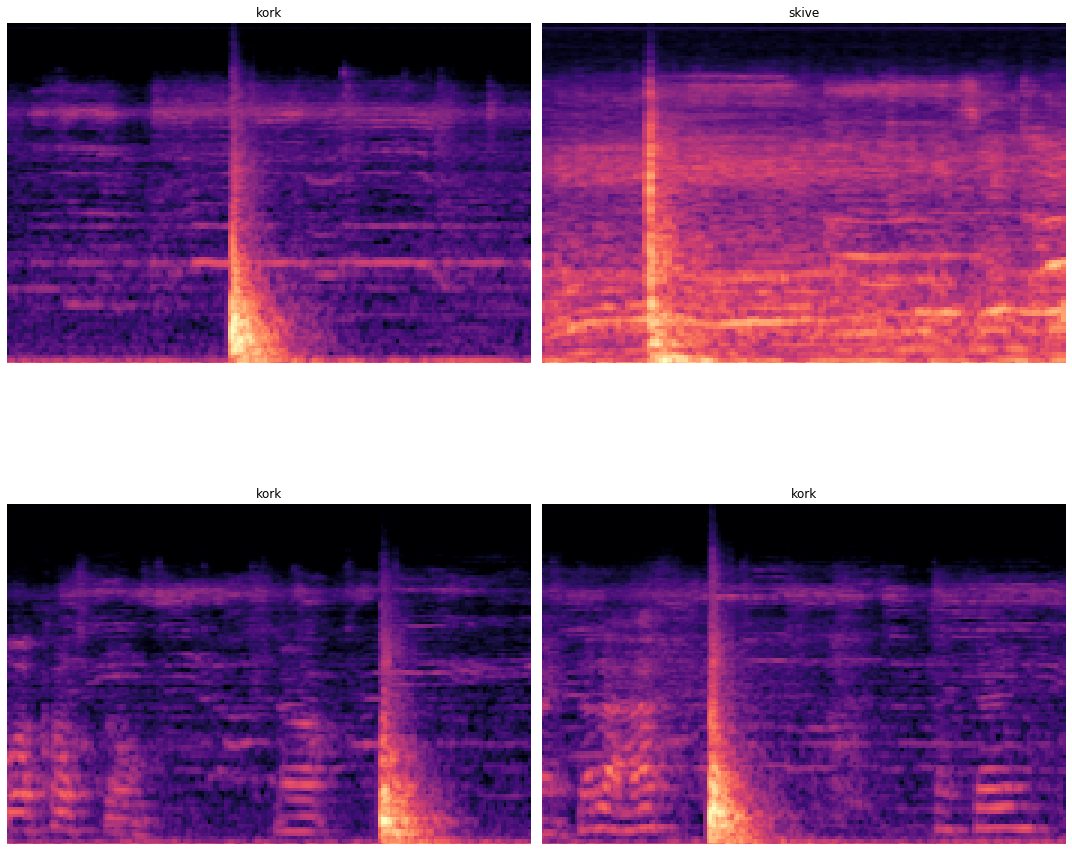

In [5]:
data = ImageDataBunch.from_folder(path, train="train_melspecs", valid='val_melspecs', ds_tfms=None, bs=bs)
data.normalize(imagenet_stats)
data.show_batch(rows=2, figsize=(15,15))

In [6]:
data

ImageDataBunch;

Train: LabelList (69 items)
x: ImageList
Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465)
y: CategoryList
blink,blink,blink,blink,blink
Path: /home/sathiesh/ml/audio_classification/nbs/../data;

Valid: LabelList (21 items)
x: ImageList
Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465)
y: CategoryList
blink,blink,blink,blink,blink
Path: /home/sathiesh/ml/audio_classification/nbs/../data;

Test: None

In [7]:
print(data.classes) 

['blink', 'kork', 'skive']


## Training

In [16]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps =0.5)

In [17]:
denne1 = [1,2,3]
denne2 = [2,3,4]
denne3 = denne1+denne2

In [13]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 151, 233]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 151, 233]       128        True      
______________________________________________________________________
ReLU                 [64, 151, 233]       0          False     
______________________________________________________________________
MaxPool2d            [64, 76, 117]        0          False     
______________________________________________________________________
Conv2d               [64, 76, 117]        36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 76, 117]        128        True      
______________________________________________________________________
ReLU                 [64, 76, 117]        0          False     
___________________________________________________

In [10]:
#learn.unfreeze()
#learn.summary()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


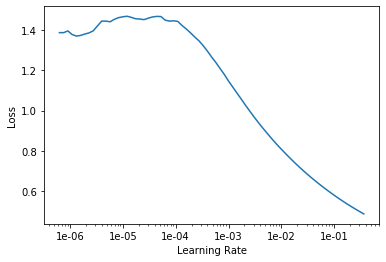

In [11]:
learn.lr_find()
learn.recorder.plot()

In [45]:
lr= 3e-2
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.205011,0.948078,0.523810,00:01
1,0.763800,0.666985,0.809524,00:01
2,0.540411,0.536705,0.761905,00:01
3,0.399718,0.988318,0.666667,00:01
4,0.317989,1.366784,0.619048,00:01
5,0.267844,1.015595,0.714286,00:01
6,0.229094,1.279289,0.666667,00:01
7,0.196476,0.972291,0.761905,00:01
8,0.171547,0.629958,0.809524,00:01
9,0.151206,0.453072,0.857143,00:01


In [46]:
learn.save('stage-1')

In [50]:
#learn.unfreeze()

In [12]:
#learn.lr_find()
#learn.recorder.plot()

In [18]:
learn.fit_one_cycle(4, slice(1e-6,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.000125,0.095356,0.904762,00:02
1,0.013167,0.412462,0.857143,00:01
2,0.010605,1.021936,0.761905,00:01
3,0.008475,0.767439,0.809524,00:01


In [19]:
#learn.save('stage-2')

In [24]:
data = ImageDataBunch.from_folder(path, train="train_melspecs", valid='val_melspecs', ds_tfms=None, size=256, bs=bs)
data.normalize(imagenet_stats)
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [25]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


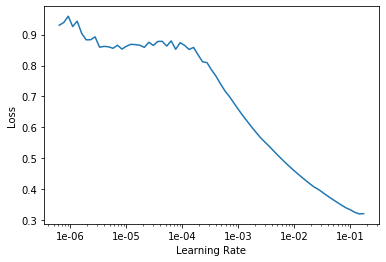

In [26]:
learn.lr_find()
learn.recorder.plot()

In [29]:
lr = 1e-2

In [30]:
learn.fit_one_cycle(30, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.006775,0.583193,0.904762,00:02
1,0.003367,0.569937,0.904762,00:02
2,0.002205,0.595346,0.904762,00:02
3,0.001623,0.621476,0.904762,00:02
4,0.001279,0.639140,0.904762,00:02
5,0.001051,0.675815,0.904762,00:02
6,0.001003,0.661208,0.904762,00:02
7,0.000861,0.661899,0.904762,00:02
8,0.000779,0.647354,0.904762,00:02
9,0.000687,0.644592,0.904762,00:02


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/sathiesh/anacond

KeyboardInterrupt: 

In [18]:
learn.save('stage-3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


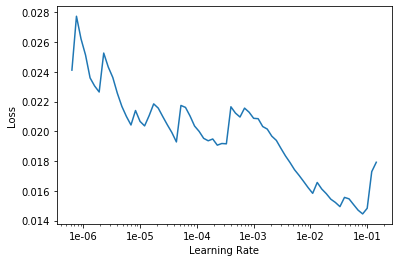

In [22]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(1, slice(1e-4,lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.062225,0.741472,0.222222,00:02


In [16]:
learn.save('stage-4')

## Interpretation

In [26]:
import fastai.vision as fvision

In [27]:
class DatasetFormatter():
    "Returns a dataset with the appropriate format and file indices to be displayed."
    @classmethod
    def from_toplosses(cls, learn, n_imgs=None, **kwargs):
        "Gets indices with top losses."
        train_ds, train_idxs = cls.get_toplosses_idxs(learn, n_imgs, **kwargs)
        return train_ds, train_idxs

    @classmethod
    def get_toplosses_idxs(cls, learn, n_imgs, **kwargs):
        "Sorts `ds_type` dataset by top losses and returns dataset and sorted indices."
        dl = learn.data.fix_dl
        if not n_imgs: n_imgs = len(dl.dataset)
        _,_,top_losses = learn.get_preds(ds_type=DatasetType.Fix, with_loss=True)
        idxs = torch.topk(top_losses, n_imgs)[1]
        return cls.padded_ds(dl.dataset, **kwargs), idxs

In [28]:
learn.load('stage-1');

In [29]:
from fastai.vision import *

In [30]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

AttributeError: type object 'DatasetFormatter' has no attribute 'padded_ds'

In [49]:
preds,y,losses = learn.get_preds(with_loss=True,ds_type=fvision.DatasetType.Train)

In [50]:
preds.shape

torch.Size([64, 3])

In [51]:
interp = ClassificationInterpretation.from_learner(learn,ds_type=fvision.DatasetType.Train)

In [52]:
interp.preds.shape

torch.Size([64, 3])

In [53]:
y_true = np.array(interp.y_true).ravel()
y_preds = np.array(interp.preds).ravel()

In [54]:
y_preds.shape

(192,)

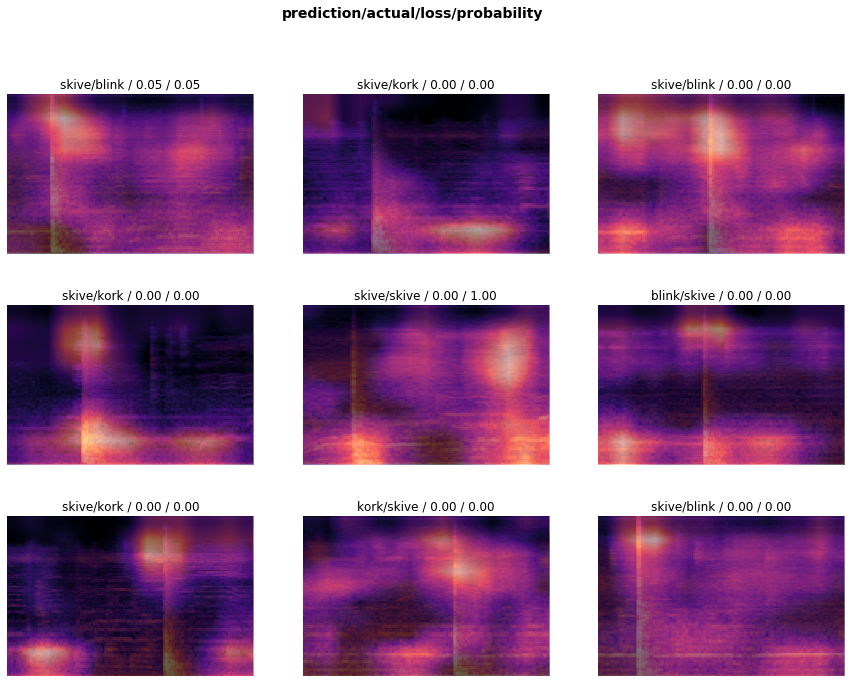

In [55]:
interp.plot_top_losses(9, figsize=(15,11))

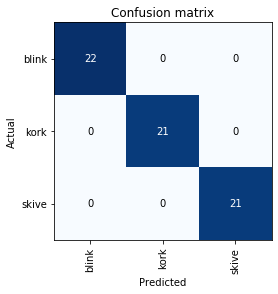

In [56]:
interp.plot_confusion_matrix()

In [57]:
interp.pred_class

tensor([1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 0, 1, 0, 0, 1, 1, 2, 2, 1, 1, 1,
        0, 0, 0, 2, 1, 2, 0, 0, 0, 1, 2, 2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1,
        0, 2, 2, 1, 1, 1, 1, 0, 1, 2, 2, 0, 2, 0, 2, 2])

#### Heatmap


Category skive

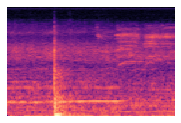

In [99]:
idx=10
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [116]:
m = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [139]:
from fastai.callbacks.hooks import *

In [157]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            print(int(cat))
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [158]:
hook_a,hook_g = hooked_backward()

2


In [159]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 10, 15])

In [160]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([10, 15])

In [175]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

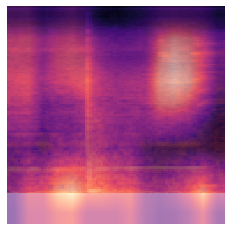

In [176]:
show_heatmap(avg_acts)

# Production model

In [58]:
learn.export()